In [53]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Data Preparation

In [54]:
file_path = Path("crypto_data.csv")
crypto_df = pd.read_csv(file_path)
#Only coins that are trading
crypto_df = crypto_df[crypto_df['IsTrading']==True]
#Drop IsTrading Column
crypto_df = crypto_df.drop(columns=['IsTrading'])
#Remove rows that have at least one null value
crypto_df = crypto_df.dropna(how='any',axis=0)
#TotalCoinsMined > 0
crypto_df = crypto_df[crypto_df['TotalCoinsMined']>0]
#Remove Coin Name
crypto_df = crypto_df.drop(columns=['CoinName'])
crypto_df = crypto_df.drop(columns=['Unnamed: 0'])
crypto_df

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,42
2,Scrypt,PoW/PoS,1.055185e+09,532000000
5,X13,PoW/PoS,2.927942e+10,314159265359
7,SHA-256,PoW,1.792718e+07,21000000
8,Ethash,PoW,1.076842e+08,0
...,...,...,...,...
1238,SHA-256,DPoS,2.000000e+09,2000000000
1242,Scrypt,PoW/PoS,1.493105e+07,250000000
1245,CryptoNight,PoW,9.802226e+08,1400222610
1246,Equihash,PoW,7.296538e+06,21000000


In [55]:
algorithms = {}
algorithmsList = crypto_df['Algorithm'].unique().tolist()
for i in range(len(algorithmsList)):
    algorithms[algorithmsList[i]] = i

proofType = {}
proofTypeList = crypto_df['ProofType'].unique().tolist()
for i in range(len(proofTypeList)):
    proofType[proofTypeList[i]] = i

crypto_df = crypto_df.replace(({'Algorithm':algorithms}))
crypto_df = crypto_df.replace(({'ProofType':proofType}))
crypto_df.dtypes

Algorithm            int64
ProofType            int64
TotalCoinsMined    float64
TotalCoinSupply     object
dtype: object

In [56]:
# Standarize data with StandarScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(crypto_df[['TotalCoinsMined', 'TotalCoinSupply']])
new_df_crypto = pd.DataFrame(scaled_data, columns=crypto_df.columns[2:])
new_df_crypto['Algorithm']=crypto_df['Algorithm'].values
new_df_crypto['ProofType']=crypto_df['ProofType'].values
new_df_crypto

,TotalCoinsMined,TotalCoinSupply,Algorithm,ProofType
0,-0.117108,-0.152870,0,0
1,-0.093970,-0.145009,0,0
2,0.524946,4.489424,1,0
3,-0.116715,-0.152560,2,1
4,-0.114747,-0.152870,3,1
...,...,...,...,...
527,-0.073251,-0.123317,2,10
528,-0.116781,-0.149176,0,0
529,-0.095613,-0.132179,18,1
530,-0.116948,-0.152560,6,1


## Dimensionality Reduction

In [57]:
#PCA
pca = PCA(n_components=2)

In [58]:
crypto_pca = pca.fit_transform(new_df_crypto)

In [59]:
pca.explained_variance_ratio_.sum()

0.9931101998659495

In [61]:
tsne = TSNE(learning_rate=250)
tsne_features = tsne.fit_transform(new_df_crypto)

In [62]:
tsne_features.shape

(532, 2)

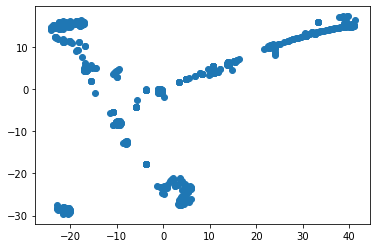

In [63]:
plt.scatter(tsne_features[:,0], tsne_features[:,1])
plt.show()

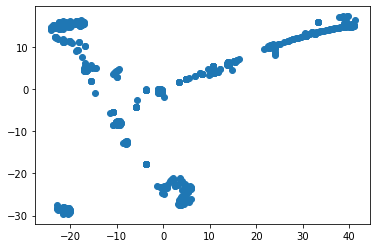

In [65]:
plt.scatter(tsne_features[:,0], tsne_features[:,1])
plt.show()